In [101]:
# https://facebook.github.io/prophet/docs/quick_start.html

# https://github.com/Joshuaek/bitcoin-forecast/blob/master/Bitcoin%2Bprice%2Bforecast.ipynb
# https://plot.ly/python/line-charts/

#

In [102]:
# Import the libraries we will use
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
#from sklearn.metrics import mean_squared_error
import plotly.offline as pl
import plotly.graph_objs as go
pl.init_notebook_mode(connected=True)
#from datetime import datetime

In [103]:
exchange = ('bitstamp_btc_usd','cex_btc_usd','exmo_btc_usd','bitfinex_btc_usd','kraken_btc_usd', 'gdax_btc_usd')

In [104]:
# Control
n = 0 # Exchange number
time_period = 'H' # '60s' '30min' 'H' 'D' -- prediction time
CI = 0.80 # Confidence interval
cps = 0.05 # Adjusting trend flexibility. Increasing it will make the trend more flexible
mcmc = 0 # To get uncertainty in seasonality, you must do full Bayesian sampling

In [105]:
# Read ask-bid price from the file
series_exch = pd.read_csv(exchange[n]+'.csv', index_col=0)
#series.columns = ['ds', 'asp', 'bid'] # Columns names
#series = series_all[series_all['exchange']==Exchange[n]].copy() # Any Exchange
#series = series_all[series_all['exchange']==Exchange[n]] # Any Exchange
series_exch.index = pd.to_datetime(series_exch.index, unit='ms') # Time converting and +3 hour
series_exch.tail()

,bid,ask
time,,
2018-05-11 05:05:00.468,8949.42,8949.99
2018-05-11 05:05:03.697,8949.43,8949.44
2018-05-11 05:05:08.050,8950.45,8954.99
2018-05-11 05:05:12.084,8950.45,8954.99
2018-05-11 05:05:15.018,8951.71,8956.96


In [106]:
series_period = series_exch.resample(time_period).mean()
series_period.tail()

,bid,ask
time,,
2018-05-11 01:00:00,8926.377867,8932.513881
2018-05-11 02:00:00,8926.432098,8931.586386
2018-05-11 03:00:00,8917.685862,8923.974786
2018-05-11 04:00:00,8936.493103,8940.842086
2018-05-11 05:00:00,8939.498235,8946.058706


In [107]:
# btc_bid = go.Scatter(
#             x = series_exch.index,
#             y = series_exch['bid'],
#             name = 'Exchange rate, '+time_period,
#             line = dict(
#             color = 'green',
#             width = 2,
#             #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
#             )            
# )
# data = [btc_bid]
# # Edit the layout
# layout = dict(title = 'BTC bid price',
#               xaxis = dict(title = 'Time'),
#               yaxis = dict(title = 'USD'),
#               )
# fig = dict(data=data, layout=layout)
# pl.iplot(fig, filename='styled-line')

In [108]:
# Creating dataframe and log-transform y
data_bid = {'ds': series_period.index, 'y': np.log(series_period['bid'])}
#data_bid = {'ds': series_period.index, 'y': series_period['bid']}
df_bid = pd.DataFrame(data=data_bid)
print(df_bid.tail())

                                     ds         y
time                                             
2018-05-11 01:00:00 2018-05-11 01:00:00  9.096766
2018-05-11 02:00:00 2018-05-11 02:00:00  9.096772
2018-05-11 03:00:00 2018-05-11 03:00:00  9.095792
2018-05-11 04:00:00 2018-05-11 04:00:00  9.097899
2018-05-11 05:00:00 2018-05-11 05:00:00  9.098235


In [109]:
# FB Prophet
model = Prophet(interval_width=CI, changepoint_prior_scale=cps, daily_seasonality=True, weekly_seasonality=True, mcmc_samples=mcmc) # Prophet controls
#model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True, interval_width=CI, changepoint_prior_scale=cps, mcmc_samples=mcmc) # Prophet controls
model.fit(df_bid); #fit the model with your dataframe
future_data = model.make_future_dataframe(periods=1, freq=time_period)
#print(future_data.tail())
forecast_data = model.predict(future_data)
print(forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/yevhen/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



                    ds      yhat  yhat_lower  yhat_upper
62 2018-05-11 02:00:00  9.095152    9.092700    9.097447
63 2018-05-11 03:00:00  9.095378    9.093044    9.097565
64 2018-05-11 04:00:00  9.096944    9.094443    9.099326
65 2018-05-11 05:00:00  9.099149    9.096893    9.101415
66 2018-05-11 06:00:00  9.102056    9.099156    9.104960


In [110]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-1:]

,ds,yhat,yhat_lower,yhat_upper
66,2018-05-11 06:00:00,9.102056,9.099156,9.10496


In [111]:
# Current price
round(series_period['bid'].values[-1])

8939.0

In [112]:
# upper predicted price
round(np.exp(forecast_data['yhat_upper'].values[-1]),2)

8999.82

In [113]:
# predicted price
round(np.exp(forecast_data['yhat'].values[-1]),2)

8973.72

In [114]:
# lower predicted price
round(np.exp(forecast_data['yhat_lower'].values[-1]),2)

8947.73

In [115]:
if series_period['bid'].values[-1] < np.exp(forecast_data['yhat_lower'].values[-1]):
    print('BID is going UP :)')                                          
elif series_period['bid'].values[-1] > np.exp(forecast_data['yhat_upper'].values[-1]):
    print('BID is going DOWN :(')    
else:
    print('That nothing is known :|')

BID is going UP :)


In [116]:
if 7 < 5:
    print('BID is going UP !!!')                                          
elif 7 > 8:
    print('BID is going DOWN')    
else:
    print('That nothing is known')

That nothing is known


In [117]:
# bid_pred = go.Scatter(
#             x = forecast_data['ds'],
#             y = np.exp(forecast_data['yhat']),
#             name = 'Forecast, '+time_period,
#             line = dict(
#             color = 'blue',
#             width = 2,
#             #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
#             )            
# )
# bid_upper = go.Scatter(
#             x = forecast_data['ds'],
#             y = np.exp(forecast_data['yhat_upper']),
#             showlegend=False,
#             name = '+ CI',
#             line = dict(
#             color = 'blue',
#             width = 2,
#             dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
#             )            
# )
# bid_lower = go.Scatter(
#             x = forecast_data['ds'],
#             y = np.exp(forecast_data['yhat_lower']),
#             showlegend=False,
#             name = '- CI',
#             line = dict(
#             color = 'blue',
#             width = 2,
#             dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
#             )            
# )
# bid_usd = go.Scatter(
#             x = series_period.index,
#             y = series_period['bid'],
#             name = 'Exchange rate, '+time_period,
#             line = dict(
#             color = 'green',
#             width = 2,
#             #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
#             )            
# )
# data = [bid_pred, bid_upper, bid_lower, bid_usd]
# # Edit the layout
# layout = dict(title = 'BTC bid price',
#               xaxis = dict(title = 'Time'),
#               yaxis = dict(title = 'USD'),
#               )
# fig = dict(data=data, layout=layout)
# pl.iplot(fig, filename='styled-line')

In [118]:
bid_upper = go.Scatter(
            x = forecast_data['ds'],
            y = np.exp(forecast_data['yhat_upper']),
            #fill='tonexty',
            showlegend=False,
            name = '+ CI',
            line = dict(
            color = 'transparent',
            #width = 1,
            #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
            )            
)
bid_pred = go.Scatter(
            x = forecast_data['ds'],
            y = np.exp(forecast_data['yhat']),
            fill='tonexty',
            fillcolor='skyblue',
            name = 'Forecast, '+time_period,
            line = dict(
            color = 'blue',
            width = 2,
            #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
            )            
)
bid_lower = go.Scatter(
            x = forecast_data['ds'],
            y = np.exp(forecast_data['yhat_lower']),
            fill='tonexty',
            fillcolor='skyblue',
            showlegend=False,
            name = '- CI',
            line = dict(
            color = 'transparent',
            #width = 1,
            #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
            )            
)
bid_usd = go.Scatter(
            x = series_period.index,
            y = series_period['bid'],
            name = 'Exchange rate, '+time_period,
            line = dict(
            color = 'green',
            width = 2,
            #dash = 'dash' # dash options include 'dash', 'dot', and 'dashdot'
            )            
)
data = [bid_upper, bid_pred, bid_lower, bid_usd]
layout = dict(title = 'BTC bid price',
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'USD'),
              paper_bgcolor='rgb(255,255,255)',
                plot_bgcolor='rgb(229,229,229)',
              )    
fig = dict(data=data, layout=layout)
pl.iplot(fig, filename='styled-line')

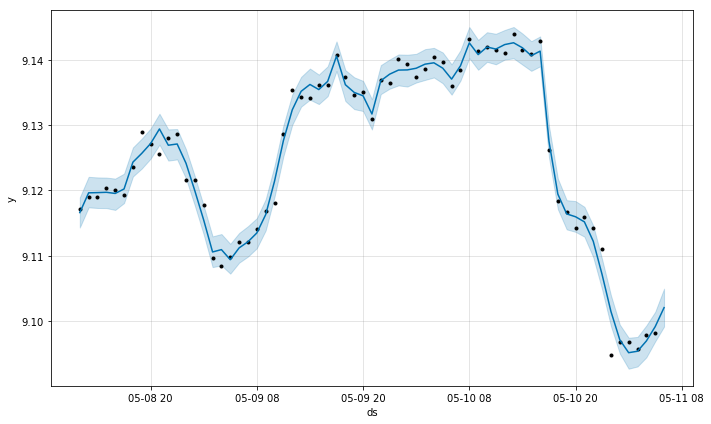

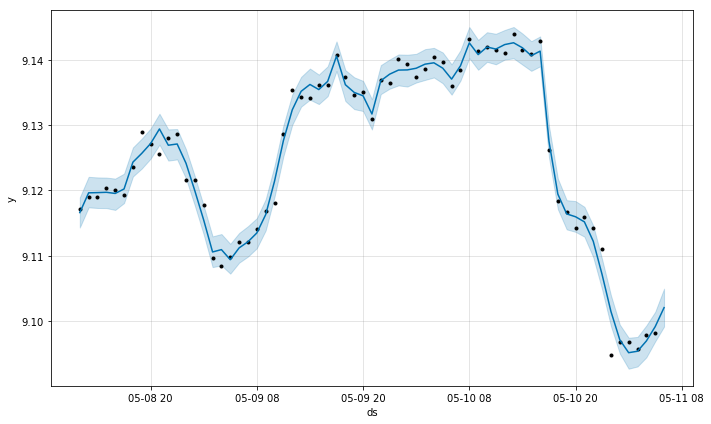

In [119]:
model.plot(forecast_data)

In [120]:
#model.plot_weekly()

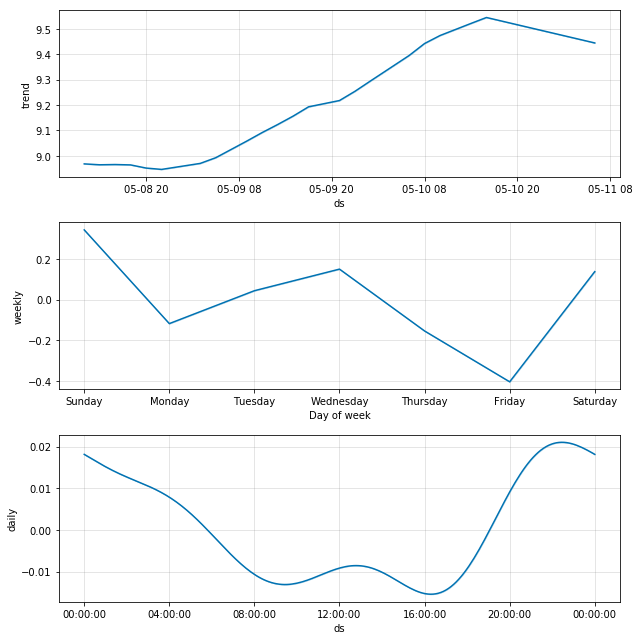

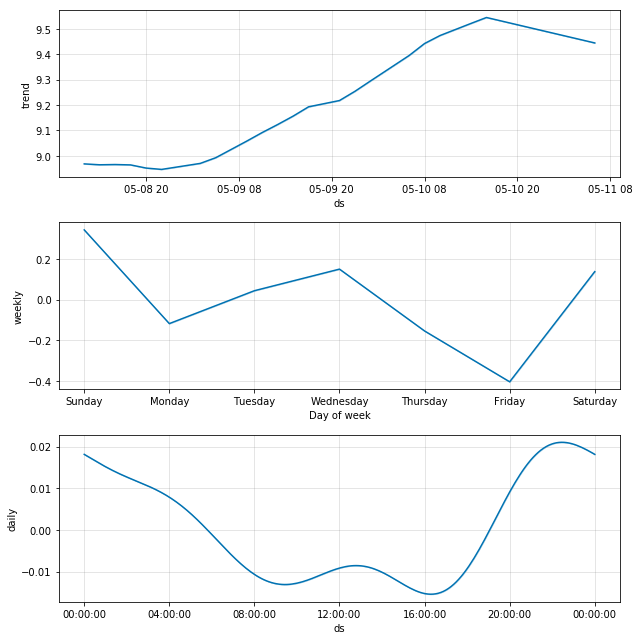

In [121]:
model.plot_components(forecast_data)

In [122]:
# Cross validation procedure
df_cv = cross_validation(model, horizon = '12H')
df_cv.head()

/Users/yevhen/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-10 06:00:00,9.141499,9.139676,9.143619,9.135972,2018-05-10 05:00:00
1,2018-05-10 07:00:00,9.146517,9.139516,9.153565,9.138497,2018-05-10 05:00:00
2,2018-05-10 08:00:00,9.157490,9.143882,9.173433,9.143174,2018-05-10 05:00:00
3,2018-05-10 09:00:00,9.174927,9.152862,9.198629,9.141356,2018-05-10 05:00:00
4,2018-05-10 10:00:00,9.197075,9.165966,9.231659,9.142013,2018-05-10 05:00:00


In [123]:
#help(Prophet)

In [124]:
# MSE
round(np.sum((df_cv['yhat']-df_cv['y'])**2),3)

0.781